# Introduction
This notebook is a personal project. The goal is to accurately forecast indoor/supply temperatures based on other variables such as external temperature, exhaust temperature,recirculation temperature and humidity. I aim to practise my feature engineering, data visualization and basic modelling.

In [39]:
import pandas as pd
import numpy as np
import glob
import time

import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from functools import reduce
from scipy import stats

In [2]:
path = r"C:\Users\Roy\Desktop\ForecastTemperature"

def read_ahu_one():

    ahu_one = "\AHU1\\"

    exh = pd.read_csv(path + ahu_one + "ahu1_evac.csv")
    ext = pd.read_csv(path + ahu_one + "ahu1_ext.csv")
    hum = pd.read_csv(path + ahu_one + "ahu1_hum.csv")
    sup = pd.read_csv(path + ahu_one + "ahu1_in.csv")
    rec = pd.read_csv(path + ahu_one + "ahu1_rec.csv")

    exh.columns = ['date', 'exh'] # Exhaust temperature
    ext.columns = ['date', 'ext'] # Outdoor temperature
    hum.columns = ['date', 'hum'] # Humidity
    sup.columns = ['date', 'sup'] # Supply temperature
    rec.columns = ['date', 'rec'] # Recirculation temperature

    return exh, ext, hum, sup, rec

evac, ext, hum, sup, rec = read_ahu_one()

def MergeData():

    list_of_data = [evac, ext, hum, sup, rec]

    data = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), list_of_data)

    # Reorder columns.
    data = data[['date', 'exh', 'ext', 'hum', 'rec', 'sup']]

    return data

data = MergeData()

def PrepareData():

    evac, ext, hum, sup, rec = read_ahu_one()

    data = MergeData()

    return data

data = PrepareData()

In [3]:
def GenerateProfile(data, title_name, title_output):

    profile = ProfileReport(data, title=title_name)
    profile.to_file(output_file=title_output)

def CorrelationMap():
    
    print(data.columns)

    DC = data.iloc[:, 1:5]
    CRLN = DC.corr()

    f, ax = plt.subplots(figsize=(17, 14))
    sns.heatmap(CRLN, annot=True, fmt=".2f")
    plt.xticks(range(len(CRLN.columns)), CRLN.columns)
    plt.yticks(range(len(CRLN.columns)), CRLN.columns)
    plt.show()


In [ ]:
# def RemoveOutlierZ(data):

#     data['z'] = np.abs(stats.zscore(data['sup']))

#     print("\nHighest z-score is " + str(data['z'].max()))

#     print("\nData shape before outlier removal: " + str(data.shape))
#     data = data[data.z < 3]
#     print("Data shape after outlier removal: " + str(dat.shape))
#     z = np.abs(stats.zscore(data['sup']))
#     print("\nHighest z-score is now " + str(data['z'].max()))

In [4]:
def CalculateEnergy(data):
    """Calculates the energy necessary to
    attain a certain temperature."""

    # Creates two new columns: energy and sup_diff.
    # Energy will be calculated using specific heat.
    # Sup_diff calculates the difference in supply air temp.
    data['energy'] = None
    data['energy'] = pd.to_numeric(data['energy'], downcast='integer')
    data['sup_diff'] = data['sup'].diff()
    data['sup_diff'][0] = "34.6"

    # The approximate density of air (room temperature) is 1.292 per cubic meter (m3).
    # The cubic meter per hour in Cabin J14 is 439 m3/h.
    mass = (1.292 * 439) # Kilograms.
    specific_heat = 1012 # Joule.

    start = time.time()

    for row in data.itertuples():

        # Calculates the energy required to heat up a room.
        data['energy'] = (mass * specific_heat * data['sup_diff']).round(decimals=2)
        data['kwh'] = (data['energy'] * 0.0000002778)
        
        # Fills up zero values with the average value.
        data['energy'] = data['energy'].replace(to_replace=0, value=data['energy'].mean())

    print(data.head(n=15))

    # Sums up J and converts it to kWh.
    JouleSum = data['energy'].sum()
    kWhSum = (JouleSum * 0.0000002778)
    
    print("\nTotal energy use is {0:,.2f} in Joules.".format(JouleSum))
    print("This is {0:,.2f} in kWh.".format(kWhSum))

    stop = time.time()
    c_time = stop - start

    print("This computation took " + str((c_time / 60)) + " minutes.")

    return data

data = CalculateEnergy(data)

                        date   exh  ext   hum   rec   sup        energy  \
0   06-Jan-17 5:15:00 PM EET  27.2 -2.5  50.0  10.6  34.6  1.986020e+07   
1   06-Jan-17 5:20:00 PM EET  27.2 -2.5  50.0  10.6  34.7  5.739943e+04   
2   06-Jan-17 5:25:00 PM EET  27.2 -2.5  50.0  10.6  34.2 -2.869971e+05   
3   06-Jan-17 5:30:00 PM EET  27.2 -3.0  50.0  10.6  34.7  2.869971e+05   
4   06-Jan-17 5:35:00 PM EET  27.2 -3.5  50.0  10.6  34.2 -2.869971e+05   
5   06-Jan-17 5:40:00 PM EET  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
6   06-Jan-17 5:45:00 PM EET  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
7   06-Jan-17 5:50:00 PM EET  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
8   06-Jan-17 5:55:00 PM EET  27.2 -3.5  50.0  10.1  34.7  2.869971e+05   
9   06-Jan-17 6:00:00 PM EET  27.2 -4.0  50.0  10.1  34.7  1.599319e+02   
10  06-Jan-17 6:05:00 PM EET  27.2 -4.0  50.0  10.1  34.7  1.599319e+02   
11  06-Jan-17 6:10:00 PM EET  27.2 -3.5  50.0  10.1  34.7  1.599319e+02   
12  06-Jan-17 6:15:00 PM 

In [5]:
# Creating copy of the dataframe.
data_copy = pd.DataFrame.copy(data, deep=True)

## Feature Engineering

To optimise our model with additional variables for input, I calculate both the hourly running mean outdoor and indoor temperature, as well as the humidity. Aguilera et al. concluded that due to the thermal mass of a building, the outdoor air temperature does not have an instant effect on the air temperature indoors, which explains the importance of TRM as an input parameter to estimate TA. 

The hourly mean features are estimated based on the values within that particular hour that is otherwised measured at a five minute interval. I'm using the forward fill function as a safety measure, as the model will iterate over the values in each row. I have not tested the efficiency of also computing the hourly mean humidity, however tests will be done later to benchmark the performance and added value.

In [6]:
def CalculateRMT(data):
    """This function calculates the
    hourly running mean outdoor and 
    indoor temperatures and humidity."""
    
    data = data.set_index('date')
    data.index = pd.to_datetime(data.index, utc=True)

    # Resamples each variable into an hourly mean.
    hourly_mean_outside = data['ext'].resample('H').mean()
    hourly_mean_supply = data['sup'].resample('H').mean()
    hourly_mean_humidity = data['hum'].resample('H').mean()

    # Appends variables as fresh columns.
    data['rmot'] = hourly_mean_outside
    data['rmit'] = hourly_mean_supply
    data['rmoh'] = hourly_mean_humidity

    columns = ['rmot', 'rmit', 'rmoh']

    data[columns] = data[columns].fillna(method='ffill')
    data[columns] = data[columns].fillna(method='bfill')
    data[columns] = data[columns].round(decimals=2)
    
    print(data.head(n=10))

    return data

data = CalculateRMT(data)

                            exh  ext   hum   rec   sup        energy  \
date                                                                   
2017-01-06 17:15:00+00:00  27.2 -2.5  50.0  10.6  34.6  1.986020e+07   
2017-01-06 17:20:00+00:00  27.2 -2.5  50.0  10.6  34.7  5.739943e+04   
2017-01-06 17:25:00+00:00  27.2 -2.5  50.0  10.6  34.2 -2.869971e+05   
2017-01-06 17:30:00+00:00  27.2 -3.0  50.0  10.6  34.7  2.869971e+05   
2017-01-06 17:35:00+00:00  27.2 -3.5  50.0  10.6  34.2 -2.869971e+05   
2017-01-06 17:40:00+00:00  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
2017-01-06 17:45:00+00:00  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
2017-01-06 17:50:00+00:00  27.2 -3.5  50.0  10.1  34.2  1.599319e+02   
2017-01-06 17:55:00+00:00  27.2 -3.5  50.0  10.1  34.7  2.869971e+05   
2017-01-06 18:00:00+00:00  27.2 -4.0  50.0  10.1  34.7  1.599319e+02   

                           sup_diff       kwh  rmot  rmit  rmoh  
date                                                             
201

In [7]:
def Interpolate(data):
    """Fills up more 0 values."""

    columns = ['exh', 'ext', 'hum', 'rec',
               'sup', 'rmot', 'rmit', 'rmoh']

    data[columns] = data[columns].replace(to_replace=0, value=data[columns].mean())
    data[columns] = data[columns].round(decimals=2)

    return data

datA = Interpolate(data)    

In [62]:
data = pd.DataFrame.copy(datA, deep=True)

In [63]:
def RemoveOutlierZ(data):

    data['z'] = np.abs(stats.zscore(data['sup']))

    print("\nHighest z-score is " + str(data['z'].max()))

    print("\nData shape before outlier removal: " + str(data.shape))
    data = data[data.z < 2.5]
    print("Data shape after outlier removal: " + str(data.shape))
    z = np.abs(stats.zscore(data['sup']))
    print("\nHighest z-score is now " + str(data['z'].max()))

    return data

data = RemoveOutlierZ(data)
data_v2 = pd.DataFrame.copy(data, deep=True)


Highest z-score is 4.595157665692344

Data shape before outlier removal: (103004, 12)
Data shape after outlier removal: (100278, 12)

Highest z-score is now 2.4949638670015575


In [9]:
# Save a kernel to feature engineer the occupancy status.

In [10]:
dat = pd.DataFrame.copy(data, deep=True)

first_three = [1, 2, 3]
second_three = [4, 5, 6]
third_three = [7, 8, 9]
fourth_three = [10, 11, 12]

dat = dat.resample('D').sum()

# Extract monthly data.
jan_to_mar = dat[dat.index.to_series().dt.month.isin(first_three)]
apr_to_jun = dat[dat.index.to_series().dt.month.isin(second_three)]
jul_to_sep = dat[dat.index.to_series().dt.month.isin(third_three)]
okt_to_dec = dat[dat.index.to_series().dt.month.isin(fourth_three)]

# jan_to_mar = pd.Series.to_frame(jan_to_mar)
# apr_to_jun = pd.Series.to_frame(apr_to_jun)
# jul_to_sep = pd.Series.to_frame(jul_to_sep)
# okt_to_dec = pd.Series.to_frame(okt_to_dec)

# dat = pd.Series.to_frame(dat)

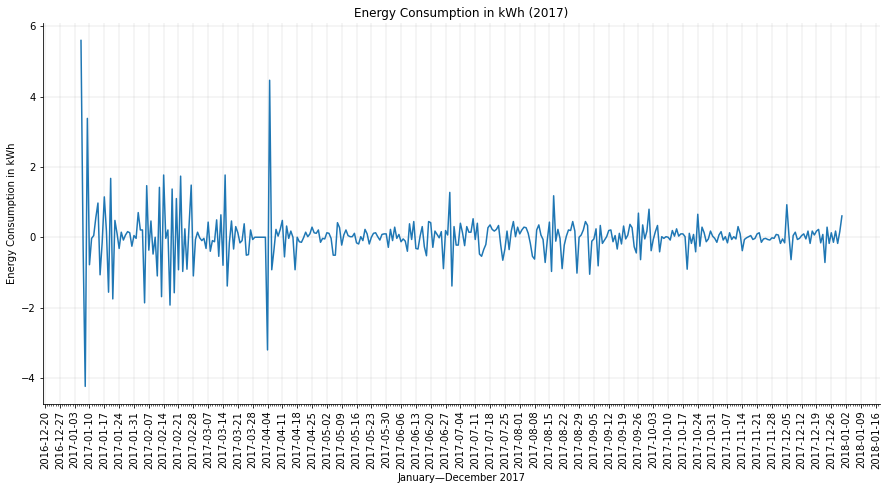

In [11]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(ax=ax, x=dat.index, y=dat['kwh'],
             data=dat).set_title('Energy Consumption in kWh (2017)')

# Sets the large ticks at the beginning of each week.
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 1))
ax.xaxis.set_minor_locator(md.DayLocator(interval = 1))

# Sets the rotation degree for readability.
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))

plt.xlabel('January—December 2017')
plt.ylabel('Energy Consumption in kWh')

plt.grid(linewidth=0.25)
sns.set_palette('colorblind')
sns.despine()

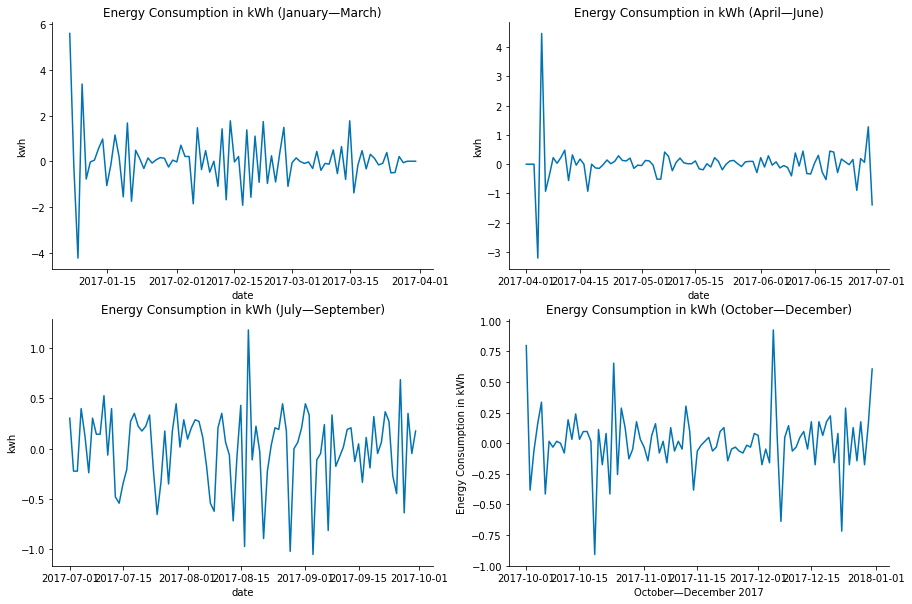

In [12]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))

# This code can be optimised.
sns.lineplot(ax=ax[0][0], x='date', y='kwh',
             data=jan_to_mar).set_title('Energy Consumption in kWh (January—March)')
plt.xlabel('January—March 2017')
plt.ylabel('Energy Consumption in kWh')
sns.lineplot(ax=ax[0][1], x='date', y='kwh', 
             data=apr_to_jun).set_title('Energy Consumption in kWh (April—June)')
plt.xlabel('April—June 2017')
plt.ylabel('Energy Consumption in kWh')
sns.lineplot(ax=ax[1][0], x='date', y='kwh', 
             data=jul_to_sep).set_title('Energy Consumption in kWh (July—September)')
plt.xlabel('July—September 2017')
plt.ylabel('Energy Consumption in kWh')
sns.lineplot(ax=ax[1][1], x='date', y='kwh', 
             data=okt_to_dec).set_title('Energy Consumption in kWh (October—December)')              
plt.xlabel('October—December 2017')
plt.ylabel('Energy Consumption in kWh')   

sns.despine()

In [13]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [14]:
data = data.reset_index()
data = data.drop(columns='date')

In [15]:
# data = data.drop(columns=['energy', 'kwh', 'sup_diff'], axis=1)

train, test = train_test_split(data, test_size=0.3)

features = ['exh', 'ext', 'hum', 'rec', 'rmot', 'rmit', 'rmoh']
target = ['sup']

train_x = train[features]
train_y = train[target]
test_x = test[features]
test_y = test[target]

print("Your features are " + str(features))
print("Your target is " + str(target))

Your features are ['exh', 'ext', 'hum', 'rec', 'rmot', 'rmit', 'rmoh']
Your target is ['sup']


In [16]:
train_x = train_x.reset_index()
train_y = train_y.reset_index()

In [17]:
print(train_x.index)

RangeIndex(start=0, stop=72102, step=1)


In [18]:
# from sklearn.model_selection import GridSearchCV

# # train_x.fillna(train_x.mean())
# # train_y.fillna(train_y.mean())

# mlp = MLPRegressor(max_iter=100)

# parameter_space = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive']
#     }

# rgr = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
# rgr.fit(train_x, train_y)

# print('Best parameters found:\n', rgr.best_params_)

# mlp = MLPRegressor(rgr)

In [73]:
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame.copy(data_v2, deep=True)
df = df.reset_index()

def SplitData(x):
    """Splits up the data in
    train and test data based on
    date time ranges."""

    sc = MinMaxScaler()

    train_x = df[0:76588].drop(columns=['date', 'sup', 'energy', 'sup_diff', 'kwh'])
    train_y = df[0:76588].filter(['sup'])
    #train_x = sc.fit_transform(train_x)
    #train_y = sc.fit_transform(train_y)

    test_x = df[76589:].drop(columns=['date', 'sup', 'energy', 'sup_diff', 'kwh'])
    test_y = df[76589:].filter(['sup'])
    #test_x = sc.fit_transform(test_x)
    #test_y = sc.fit_transform(test_y)


    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = SplitData(df)

In [82]:
mlp = MLPRegressor(activation='relu', alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate='constant', solver='adam')
mlp.fit(train_x, train_y)
pred = mlp.predict(test_x)

In [83]:
# print("Actual = %s, Predicted = %s" % (test_y[0], pred[0]))
# print("Actual = %s, Predicted = %s" % (test_y[13307], pred[13307]))
# print("Actual = %s, Predicted = %s" % (test_y[26414], pred[26414]))
comparison = pd.DataFrame(test_y, pred)
comparison.columns = comparison.columns=['prediction']
mse = mean_squared_error(test_y, pred).round(decimals=5)

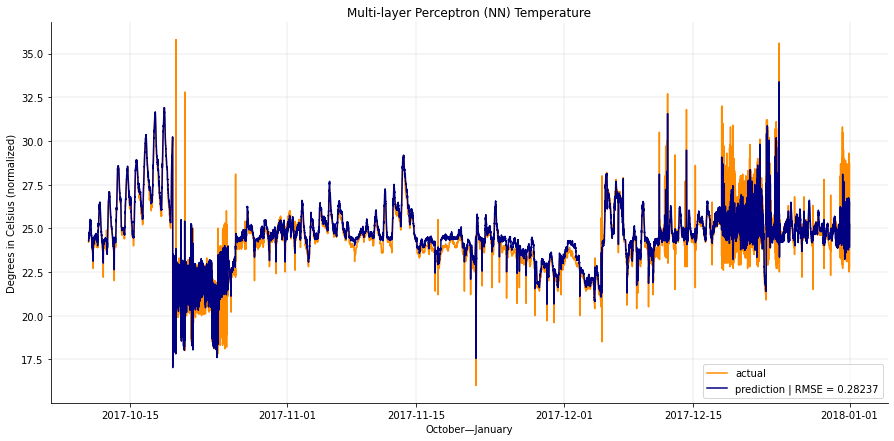

In [90]:
nn_results = df[76589:].filter(['date'])
nn_results['actual'] = test_y
nn_results['prediction'] = pred

fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(x='date', y='actual', data=nn_results, color='darkorange', ax=ax).set_title('Multi-layer Perceptron (NN) Temperature')
sns.lineplot(x='date', y='prediction', data=nn_results, color='navy', ax=ax)

ax.legend(['actual', 'prediction | RMSE = ' + str(mse)])
plt.xlabel('October—January')
plt.ylabel('Degrees in Celsius (normalized)')

plt.grid(linewidth=0.25)
sns.despine()

In [78]:
pred = mlp.predict(train_x)

comparison = pd.DataFrame(train_y, pred)
comparison.columns = comparison.columns=['prediction']
mse = mean_squared_error(train_y, pred).round(decimals=5)
print(mse)

0.25363


In [91]:
nn_results['prediction'] = nn_results['prediction'].round(decimals=2)
nn_results = nn_results.rename(columns={'prediction':'sup'})

nn_results.columns
#nn_final = CalculateEnergy(nn_results)

Index(['date', 'actual', 'sup'], dtype='object')

In [92]:
nn_final = CalculateEnergy(nn_results)

                           date  actual    sup    energy  sup_diff       kwh
76589 2017-10-10 11:00:00+00:00    24.2  24.27       NaN       NaN       NaN
76590 2017-10-10 11:05:00+00:00    24.2  24.37  57399.43      0.10  0.015946
76591 2017-10-10 11:10:00+00:00    24.3  24.31 -34439.66     -0.06 -0.009567
76592 2017-10-10 11:15:00+00:00    24.3  24.40  51659.48      0.09  0.014351
76593 2017-10-10 11:20:00+00:00    24.4  24.46  34439.66      0.06  0.009567
76594 2017-10-10 11:25:00+00:00    24.4  24.44 -11479.89     -0.02 -0.003189
76595 2017-10-10 11:30:00+00:00    24.4  24.46  11479.89      0.02  0.003189
76596 2017-10-10 11:35:00+00:00    24.3  24.43 -17219.83     -0.03 -0.004784
76597 2017-10-10 11:40:00+00:00    24.3  24.46  17219.83      0.03  0.004784
76598 2017-10-10 11:45:00+00:00    24.4  24.58  68879.31      0.12  0.019135
76599 2017-10-10 11:50:00+00:00    24.4  24.46 -68879.31     -0.12 -0.019135
76600 2017-10-10 11:55:00+00:00    24.4  24.57  63139.37      0.11  0.017540